# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data

## Part A: Preprocessing and Initial Setup [10 points]

In [100]:
import os
import warnings
warnings.filterwarnings('ignore')

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff
from collections import Counter

In [102]:
def read_arff_file(file_path):
    """
    Function to read an ARFF file and convert it into a Pandas DataFrame.
    """
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    df = df.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)
    return df

In [103]:
data_dir = 'yeast' 
yeast_df = read_arff_file(os.path.join(data_dir, 'yeast.arff'))
yeast_df.to_csv(os.path.join(f'{data_dir}/yeast.csv'), index=False)
print(f'Saved cleaned data for yeast.arff')

Saved cleaned data for yeast.arff


In [104]:
yeast_df = pd.read_csv(os.path.join(data_dir, 'yeast.csv'))
display(yeast_df.head())

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0


In [105]:
yeast_df.describe(include='all')

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,...,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,...,0.298717,0.247000,0.177079,0.198593,0.073645,0.104675,0.119570,0.751345,0.744311,0.014067
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,...,0.457790,0.431356,0.381815,0.399024,0.261246,0.306198,0.324525,0.432323,0.436338,0.117792
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.053655,-0.058734,-0.057526,-0.057149,-0.058461,-0.060212,-0.058445,-0.062849,-0.063472,-0.065010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.003649,-0.003513,0.002892,-0.000153,0.005565,0.000321,0.006179,0.001436,0.003515,0.002432,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.057299,0.048047,0.061007,0.054522,0.066286,0.059908,0.068892,0.061418,0.064958,0.063096,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.520272,0.614114,0.353241,0.568960,0.307649,0.336971,0.351401,0.454591,0.419852,0.420876,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [106]:
# Data Loading - split the features-X and class labels-Y
X, Y = yeast_df.iloc[:, :103], yeast_df.iloc[:, 103:]

# Dimensionality Check
print(f"Initial shapes of Yeast dataset: {yeast_df.shape}")

print(f"Feature matrix shape: {X.shape}")
display(X.head())

print(f"Target matrix shape: {Y.shape}")
display(Y.head())

Initial shapes of Yeast dataset: (2417, 117)
Feature matrix shape: (2417, 103)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0.006166,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0.007680,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0.096277,-0.044932,-0.089470,-0.009162,-0.012010,0.308378,-0.028053,0.026710,-0.066565,-0.122352
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,-0.083809,0.200354,-0.075716,0.196605,0.152758,-0.028484,-0.074207,-0.089227,-0.049913,-0.043893
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,-0.060467,0.044351,-0.057209,0.028047,0.029661,-0.050026,0.023248,-0.061539,-0.035160,0.067834


Target matrix shape: (2417, 14)


,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0


In [107]:
Y

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2413,1,1,0,0,0,0,0,0,0,0,0,1,1,0
2414,0,0,0,0,0,1,1,1,0,0,0,1,1,0
2415,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [108]:
single_label_counts = Y.sum(axis=0)
single_label_sorted_counts = single_label_counts.sort_values(ascending=False)
single_label_sorted_counts

Class12    1816
Class13    1799
Class2     1038
Class3      983
Class4      862
Class1      762
Class5      722
Class6      597
Class8      480
Class7      428
Class11     289
Class10     253
Class9      178
Class14      34
dtype: int64

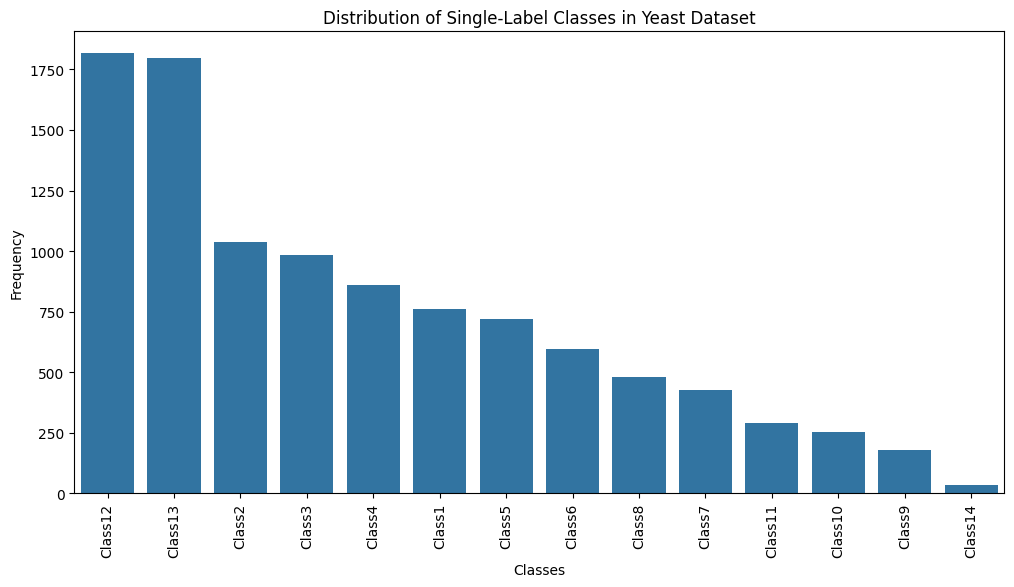

In [109]:
plt.figure(figsize=(12, 6))
sns.barplot(x=single_label_sorted_counts.index, y=single_label_sorted_counts.values            )
plt.xticks(rotation=90)
plt.title('Distribution of Single-Label Classes in Yeast Dataset')
plt.xlabel('Classes')       
plt.ylabel('Frequency')             
plt.show()

In [110]:
top_most_frequent_single_label = Y.sum().idxmax()
second_most_frequent_single_label = Y.sum().nlargest(2).idxmin()

print(f"Top most frequent single label: {top_most_frequent_single_label} with {Y[top_most_frequent_single_label].sum()} instances")
print(f"Second most frequent single label: {second_most_frequent_single_label} with {Y[second_most_frequent_single_label].sum()} instances")

Top most frequent single label: Class12 with 1816 instances
Second most frequent single label: Class13 with 1799 instances


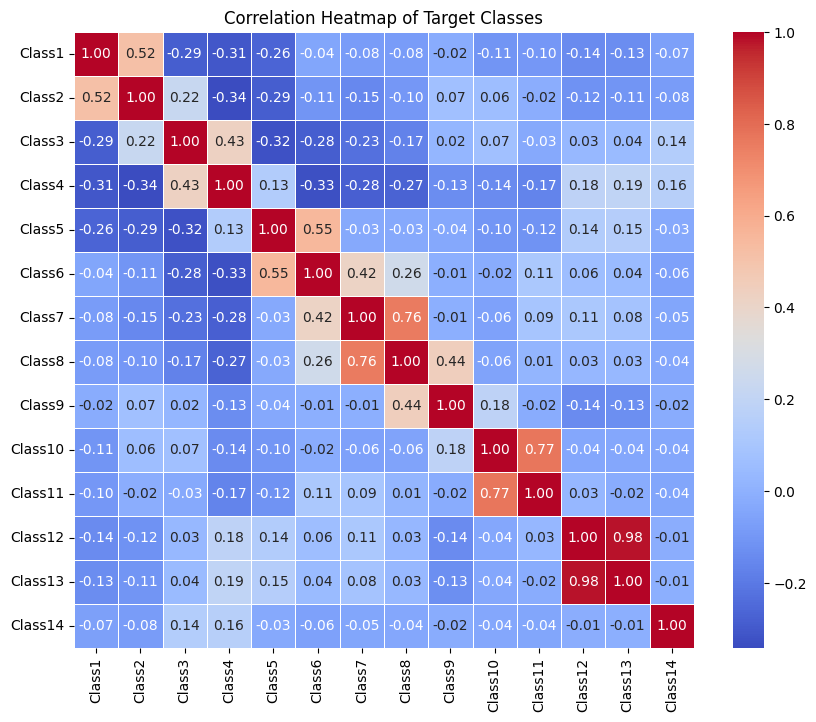

In [111]:
corr_matrix = Y.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Target Classes")
plt.show()

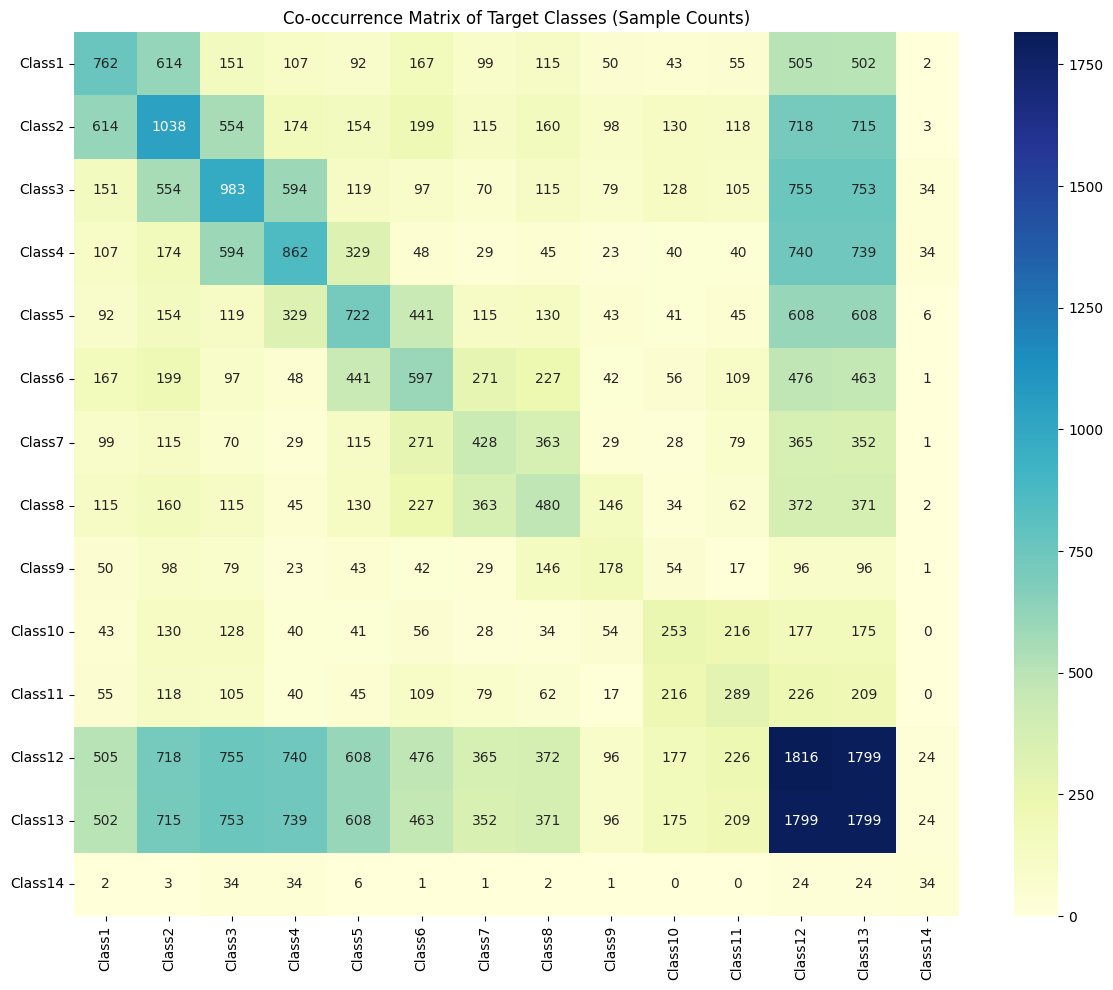

In [112]:
# Create a co-occurrence matrix with zeros (ensures numeric datatype)
class_columns = Y.columns
co_occurrence = pd.DataFrame(0, index=class_columns, columns=class_columns)

# Fill the matrix with co-occurrence counts
for i in range(len(class_columns)):
    for j in range(len(class_columns)):
        class_i = class_columns[i]
        class_j = class_columns[j]
        # Count samples where both classes occur
        co_occurrence.loc[class_i, class_j] = ((Y[class_i] == 1) & (Y[class_j] == 1)).sum()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Co-occurrence Matrix of Target Classes (Sample Counts)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Class12 and Class13 are merged because they are highly correlated and frequently co-occur, so combining them captures the dominant label pattern and reduces redundancy in the target categories.

In [113]:
Y_merged = Y.assign(Class12_13=(Y['Class12'] | Y['Class13'])).drop(columns=['Class12', 'Class13'])
print(f"Class12&Class13: {Y_merged['Class12_13'].sum()}")

Class12&Class13: 1816


In [114]:
Y_non_top = Y_merged[Y_merged['Class12_13'] == 0].drop(columns=['Class12_13'])
Y_non_top.columns

Index(['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7',
       'Class8', 'Class9', 'Class10', 'Class11', 'Class14'],
      dtype='object')

In [115]:
combos = [tuple(sorted(row.index[row == 1])) for _, row in Y_non_top.iterrows()]
top_combos = [combo for combo, _ in Counter(combos).most_common(2)]
print(f"Top combos: {top_combos}")

combo_labels = {combo: '&'.join(combo) for combo in top_combos}
for combo, label in combo_labels.items():
    print(f"    Combo: {combo} -> Label: {label}")

Top combos: [('Class1', 'Class2'), ('Class2', 'Class3')]
    Combo: ('Class1', 'Class2') -> Label: Class1&Class2
    Combo: ('Class2', 'Class3') -> Label: Class2&Class3


In [116]:
# Assign new target
def assign_label(row):
    if row['Class12_13'] == 1:
        return 'Top_Class12&Class13'
    active = tuple(sorted(row.index[row == 1]))
    return combo_labels.get(active, 'Other')

In [117]:
Y_merged['SimplifiedTarget'] = Y_merged.apply(assign_label, axis=1)
print(Y_merged['SimplifiedTarget'].value_counts())

SimplifiedTarget
Top_Class12&Class13    1816
Other                   402
Class1&Class2           131
Class2&Class3            68
Name: count, dtype: int64


We created a simplified target variable that groups the two most frequent single-label classes and the most common multi-label combination, assigning "Other" to the rest, resulting in clear, distinct categories for effective visualization.

***Why scaling is crucial before applying distance-based dimensionality reduction techniques?***

Scaling is crucial before distance-based dimensionality reduction because features with larger scales can dominate the distance calculations, distorting the true structure of the data. Proper scaling ensures all features contribute equally, leading to more meaningful and interpretable low-dimensional representations.

In [118]:
# Apply Standardization to the feature matrix X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
display(pd.DataFrame(X_scaled, columns=X.columns).head())

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.030752,-1.742591,-1.601326,-1.468980,0.594010,0.271117,2.023802,0.428070,0.683885,-0.584890,...,0.074380,-0.139039,-0.142884,-0.162409,-0.115009,0.020075,-0.320076,-0.178076,0.320417,1.178867
1,-1.079454,0.125835,-1.010264,-0.564893,-0.094933,0.499948,-0.326167,-0.809579,-0.847347,-0.167984,...,0.090608,0.281957,-0.886751,1.143263,0.521680,0.307877,-0.645355,-0.423947,-0.859425,0.096189
2,5.224059,4.109170,3.008988,0.902018,0.107939,-0.070783,-0.075781,0.136654,-0.433427,-0.252502,...,1.040237,-0.469629,-0.924791,-0.101735,-0.128129,3.284185,-0.278757,0.299908,-0.717769,-1.308110
3,1.210780,0.049537,-0.020516,0.742552,0.446738,-0.533913,0.757376,-0.083592,0.813679,0.642590,...,-0.890019,2.067892,-0.781802,2.028035,1.583559,-0.286180,-0.755161,-0.930956,-0.538974,-0.518363
4,0.419587,0.076533,-0.708369,0.832919,-0.510222,0.914530,-0.062317,0.661644,-1.396200,0.711754,...,-0.639827,0.454017,-0.589400,0.283393,0.304769,-0.514501,0.250775,-0.637002,-0.380569,0.606249


## Part B: t-SNE and Veracity Inspection [20 points]

In [119]:
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE


unique_classes = ['Top_Class12&Class13', 'Class1&Class2', 'Class2&Class3', 'Other']
class2color = {
    'Top_Class12&Class13': '#377eb8',  
    'Class1&Class2': "#F8C600",  
    'Class2&Class3': '#e41a1c',   
    'Other': '#999999'  
}
point_colors = Y_merged['SimplifiedTarget'].map(class2color)

TypeError: TSNE.__init__() got an unexpected keyword argument 'fill'

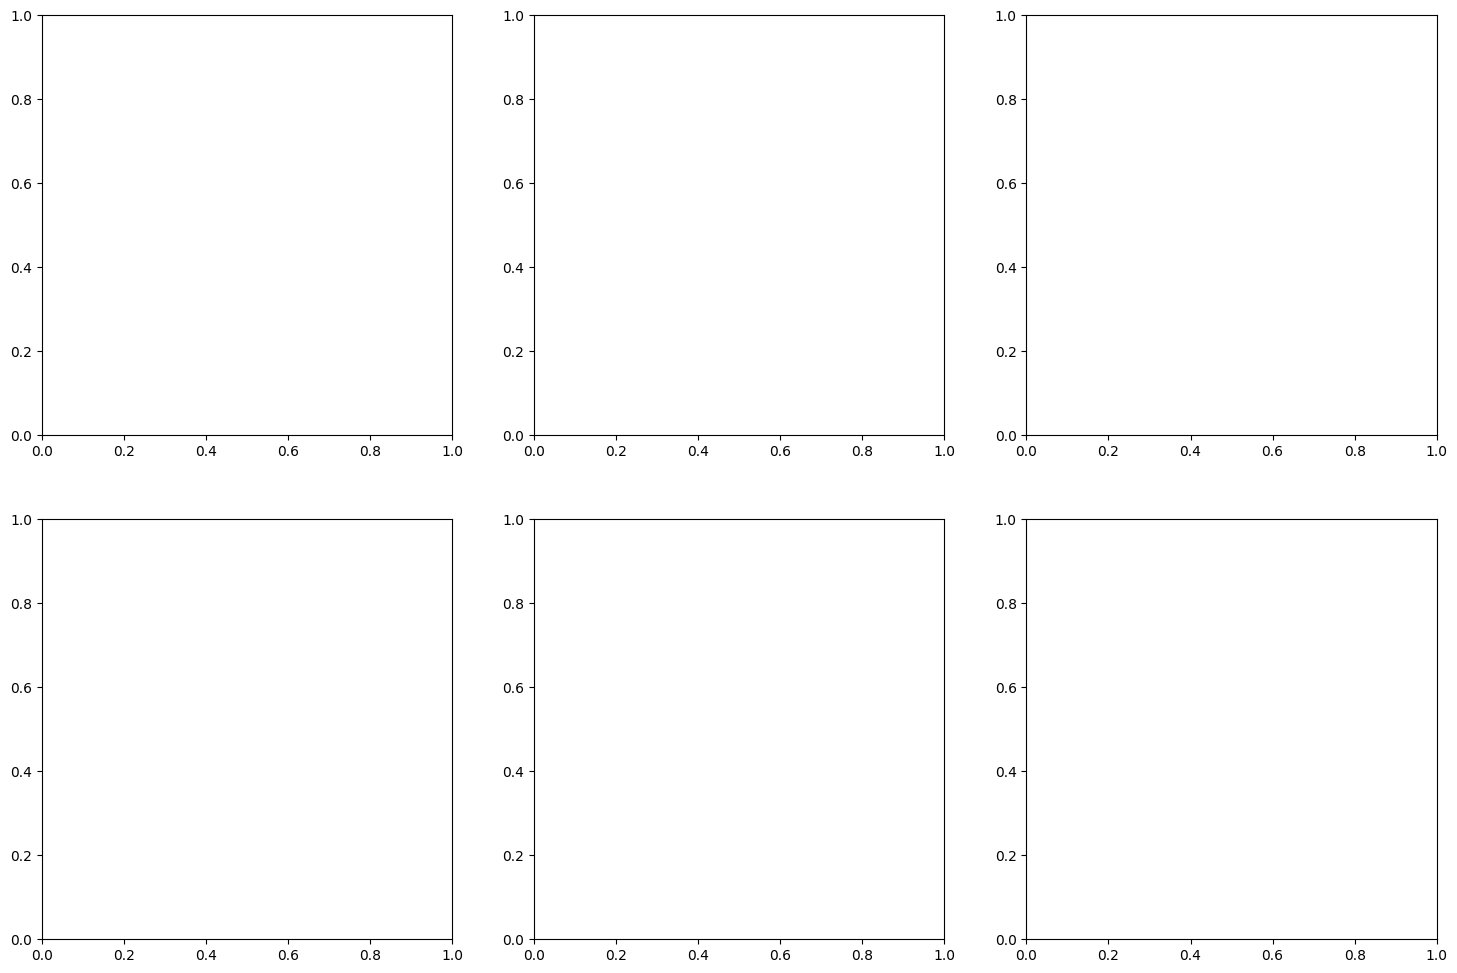

In [ ]:
perplexity_list = [5, 10, 20, 30, 40, 50]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, perplexity in enumerate(perplexity_list):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_scaled)

    scatter = axes[idx].scatter(
        X_tsne[:, 0], X_tsne[:, 1],
        c=point_colors, alpha=0.85, s=12
    )
    axes[idx].set_title(f't-SNE Perplexity={perplexity}')
    axes[idx].set_xlabel('t-SNE Dimension 1')
    axes[idx].set_ylabel('t-SNE Dimension 2')
    axes[idx].set_aspect('equal')
   
legend_handles = [
    mpatches.Patch(color=color, label=label) 
    for label, color in class2color.items()
]
fig.legend(handles=legend_handles, title='SimplifiedTarget', bbox_to_anchor=(1.02, 0.5), loc='center')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

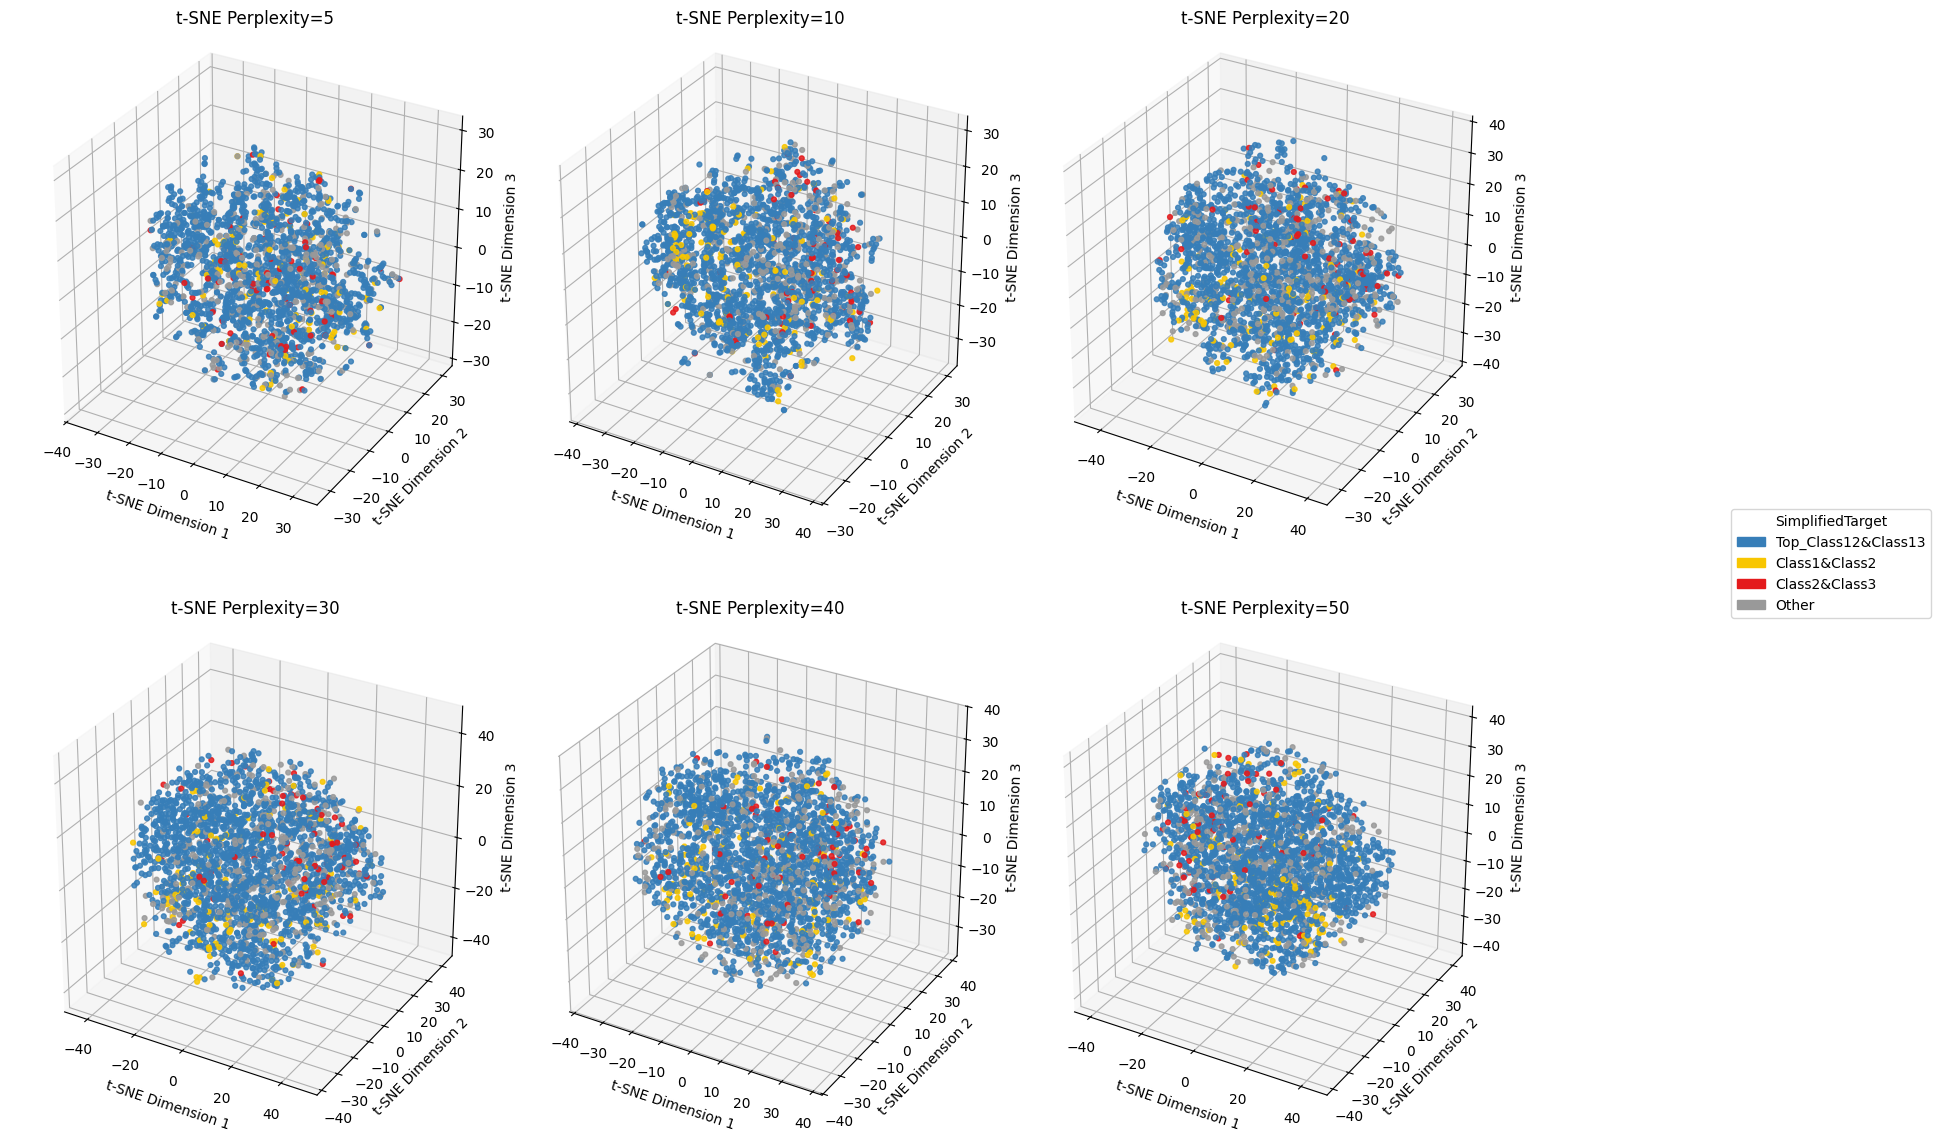

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure(figsize=(18, 12))
axes = [fig.add_subplot(2, 3, i + 1, projection='3d') for i in range(len(perplexity_list))]

for idx, perplexity in enumerate(perplexity_list):
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_scaled)

    scatter = axes[idx].scatter(
        X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
        c=point_colors, alpha=0.85, s=12
    )
    axes[idx].set_title(f't-SNE Perplexity={perplexity}')
    axes[idx].set_xlabel('t-SNE Dimension 1')
    axes[idx].set_ylabel('t-SNE Dimension 2')
    axes[idx].set_zlabel('t-SNE Dimension 3')
    axes[idx].set_box_aspect([1,1,1])  # square aspect for 3D

legend_handles = [
    mpatches.Patch(color=color, label=label) 
    for label, color in class2color.items()
]
fig.legend(handles=legend_handles, title='SimplifiedTarget', bbox_to_anchor=(1.02, 0.5), loc='center')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Comparing the t-SNE subplots at perplexity=30 (where classes like Top_Class12&Class13 show moderate clustering but with noticeable fragmentation in 'Other' gray points) to those at 40, the latter demonstrates superior clarity and balance. At perplexity=40, major categories exhibit tighter, more cohesive structures e.g., red (Class2&Class3) forms a distinct right-side aggregation without excessive scatter—while preserving local details for veracity inspection, avoiding the over-smoothing seen beyond 45. This makes 40 the optimal choice for the approximately 2417-sample yeast dataset, aligning with t-SNE recommendations to capture both global separations and subtle overlaps in multi-label gene expression patterns.

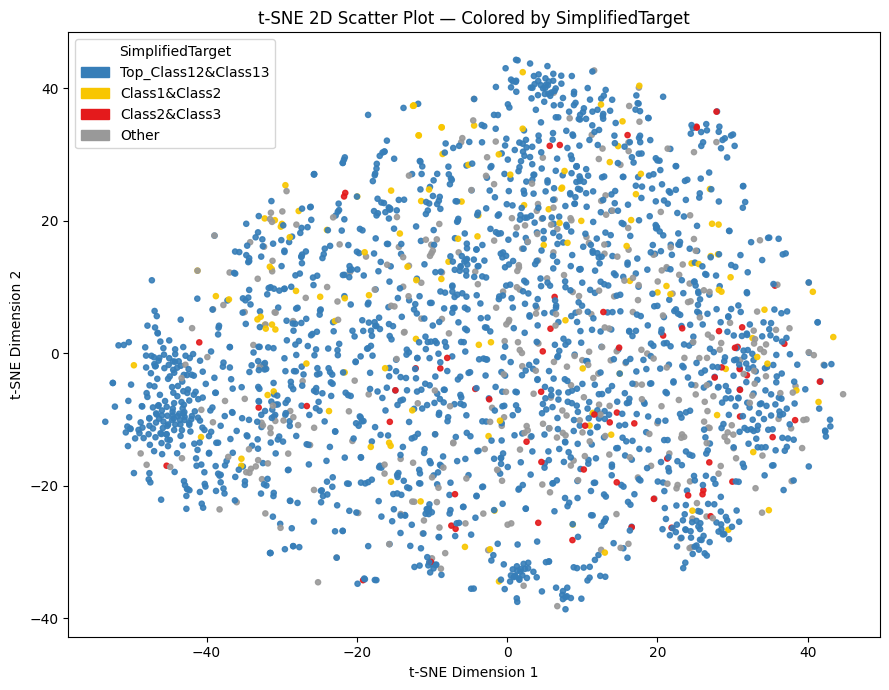

In [ ]:
# Final vizualization with chosen perplexity
tsne_final = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne_final = tsne_final.fit_transform(X_scaled)

colors_final = Y_merged['SimplifiedTarget'].map(class2color)
unique_classes = list(class2color.keys())

plt.figure(figsize=(9, 7))
plt.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c=colors_final, s=14, alpha=0.9)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE 2D Scatter Plot — Colored by SimplifiedTarget')

# Legend to map colors to category labels
legend_handles = [mpatches.Patch(color=class2color[cls], label=cls) for cls in unique_classes]
plt.legend(handles=legend_handles, title='SimplifiedTarget', loc='best')
plt.tight_layout()
plt.show()

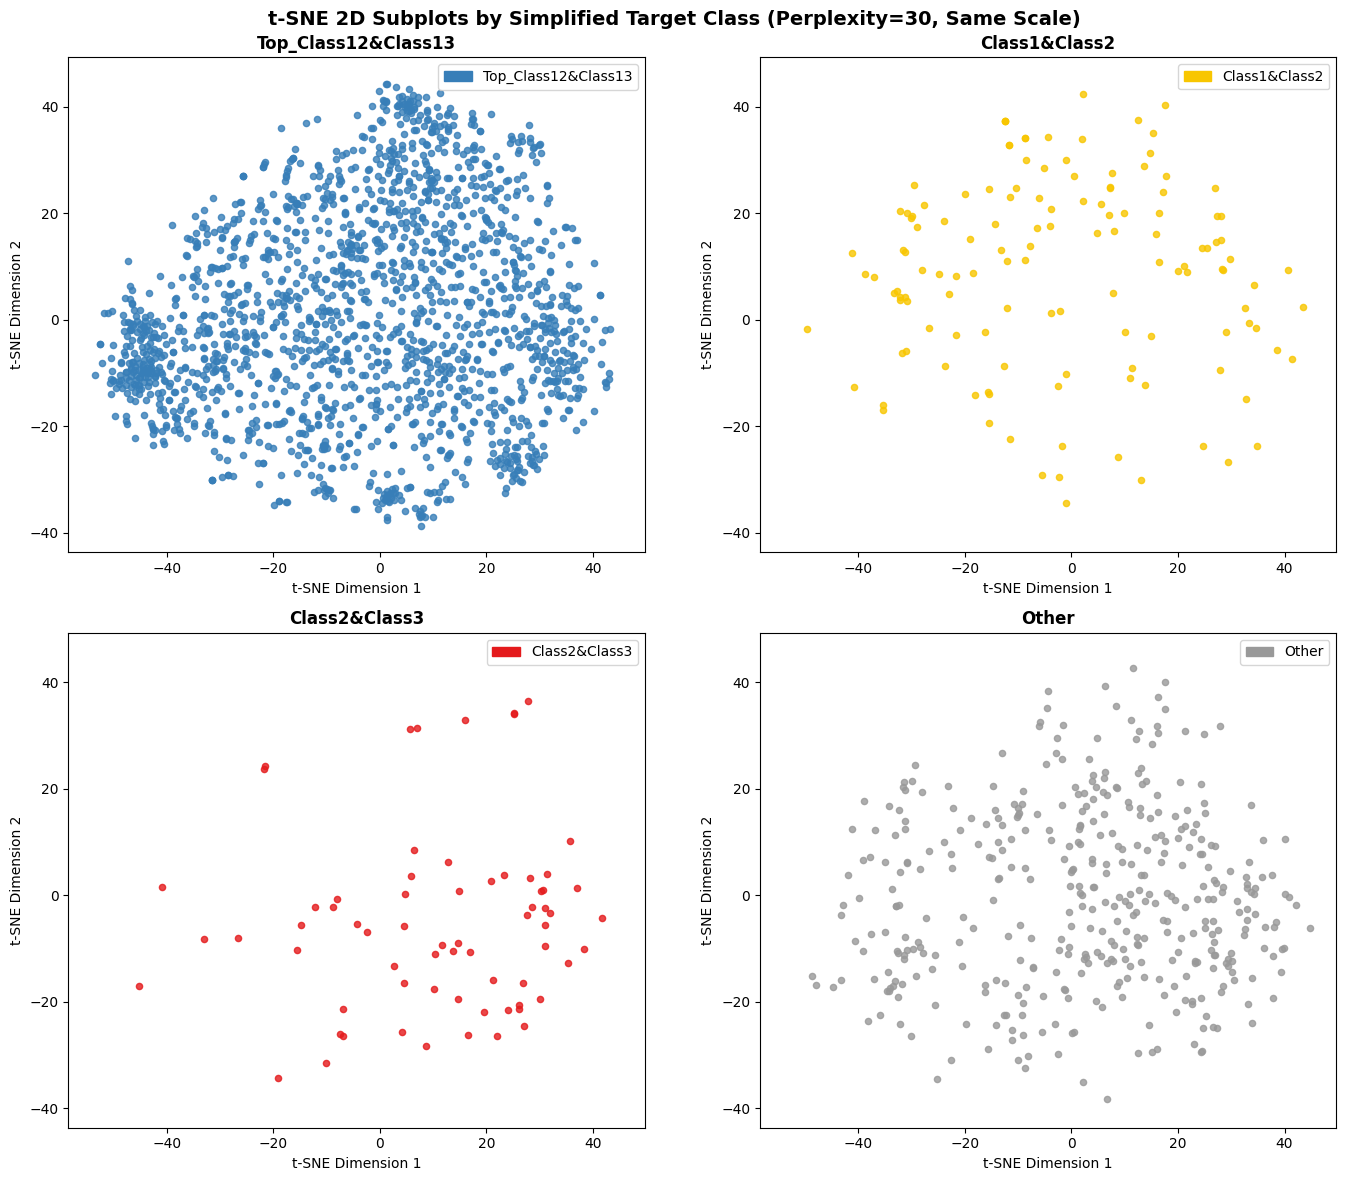

Top_Class12&Class13: 1816 points
Class1&Class2: 131 points
Class2&Class3: 68 points
Other: 402 points


In [ ]:
tsne_final = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne_final = tsne_final.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Determine common scale from full t-SNE
x_min, x_max = X_tsne_final[:, 0].min() - 5, X_tsne_final[:, 0].max() + 5
y_min, y_max = X_tsne_final[:, 1].min() - 5, X_tsne_final[:, 1].max() + 5

# Plot each class in its own subplot with same axis limits
for idx, class_label in enumerate(unique_classes):
    ax = axes[idx]
    
    class_idx = Y_merged['SimplifiedTarget'] == class_label
    ax.scatter(
        X_tsne_final[class_idx, 0], 
        X_tsne_final[class_idx, 1], 
        c=[class2color[class_label]], 
        s=20, alpha=0.8, 
        label=class_label
    )
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')  
    ax.set_title(f'{class_label}', fontsize=12, fontweight='bold')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    
    # Add legend
    legend_handle = mpatches.Patch(color=class2color[class_label], label=class_label)
    ax.legend(handles=[legend_handle], loc='upper right')

fig.suptitle('t-SNE 2D Subplots by Simplified Target Class (Perplexity=30, Same Scale)', 
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print class sizes for reference
for class_label in unique_classes:
    count = (Y_merged['SimplifiedTarget'] == class_label).sum()
    print(f"{class_label}: {count} points")

**Veracity Inspection**

**Noisy/Ambiguous Labels**

 In several areas of the plot, there are points of one color deeply embedded within a larger cluster of a different color. For example, there are isolated red ('Class2&Class3') and yellow ('Class1&Class2') points located within the large blue ('Top_Class12&Class13') cluster. This suggests that these specific genes may be mislabeled or, more likely, possess multiple functions, making their classification ambiguous

**Outliers**

There are a number of isolated points and small, distant clusters scattered at the periphery of the main data cloud. These outliers represent experiments with highly unusual gene expression profiles compared to the majority of the samples. These unusual patterns could be the result of experimental artifacts or noise, or they could represent genes with unique, uncharacterized functions or responses to specific, unrecorded experimental conditions.

**Hard-to-Learn Samples**

The central region of the plot, as well as several smaller sub-regions, show a thorough mixing of colors, particularly blue, gray, and yellow points. In these areas, the gene expression profiles of different functional categories are highly similar, making it difficult to distinguish between them. A simple classifier would likely struggle in these regions because the decision boundaries between the classes are not clear, leading to a high rate of misclassification.

## Part C: Isomap and Manifold Learning [20 points]

In [ ]:
from sklearn.manifold import Isomap

# Apply Isomap to scaled features X_scaled, reducing to 2 dimensions
isomap = Isomap(n_components=2, n_neighbors=10)  
X_isomap = isomap.fit_transform(X_scaled)

# Show output shape
print(f"Isomap output shape: {X_isomap.shape}")
print("First 5 reduced samples:")
print(X_isomap[:5])

Isomap output shape: (2417, 2)
First 5 reduced samples:
[[  9.45491338  -7.19387294]
 [-10.33212725  -4.81253984]
 [-14.10813781  -6.26622229]
 [ 14.14840271 -12.01978557]
 [-11.88343645 -10.53888932]]


**What is the fundamental difference between Isomap and t-SNE (in terms of how they preserve data structure (global vs. local))?**

Isomap preserves the global structure of the data by maintaining geodesic distances between all samples along the underlying manifold, making it effective for capturing broader relationships across the whole dataset. In contrast, t-SNE emphasizes local structure by preserving local neighbor relationships at the expense of global geometry, making it ideal for visualizing local clusters and neighborhood composition.

| Category           | t-SNE               | Isomap            |
|--------------------|---------------------|-------------------|
| Purpose/Objective  | Viz high-dim data   | Nonlin dim red    |
| Structure Preserv  | LOCAL - nearby      | GLOBAL - overall  |
| Algorithm          | Probabilistic       | Graph-based       |
| Distance Metric    | KL divergence       | Geodesic dist     |
| Complexity         | O(N²) slower        | O(N²logN) fast    |
| Best Use Cases     | Viz, clusters       | Manifold learn    |
| Advantages         | Great clusters      | Global struct     |
| Disadvantages      | Non-deterministic   | Noise sensitive   |
| Key Parameters     | Perplexity          | k neighbors       |
| Output Chars       | Tight clusters      | Global relat      |


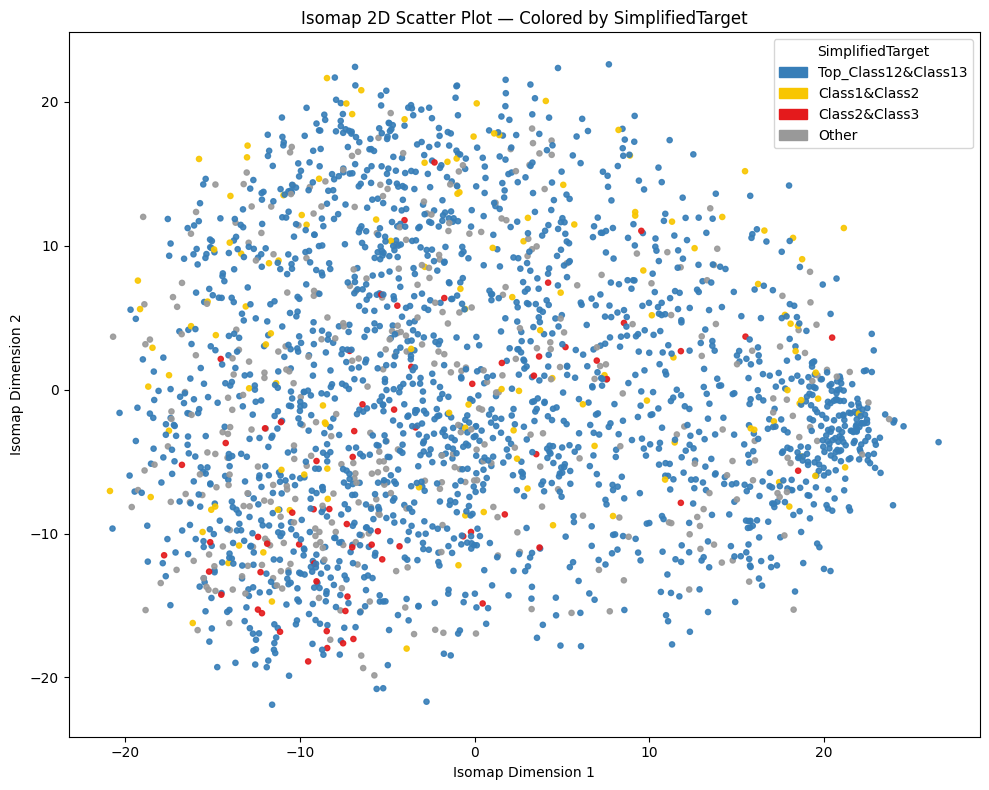

In [ ]:
# Create a 2D scatter plot of the Isomap coordinates

colors_isomap = Y_merged['SimplifiedTarget'].map(class2color)
unique_classes = list(class2color.keys())

plt.figure(figsize=(10, 8))
plt.scatter(
    X_isomap[:, 0], X_isomap[:, 1], 
    c=colors_isomap, s=14, alpha=0.9
)
plt.xlabel('Isomap Dimension 1')
plt.ylabel('Isomap Dimension 2')
plt.title('Isomap 2D Scatter Plot — Colored by SimplifiedTarget')

# Legend mapping color to label
legend_handles = [mpatches.Patch(color=class2color[cls], label=cls) for cls in unique_classes]
plt.legend(handles=legend_handles, title='SimplifiedTarget', loc='best')
plt.tight_layout()
plt.show()


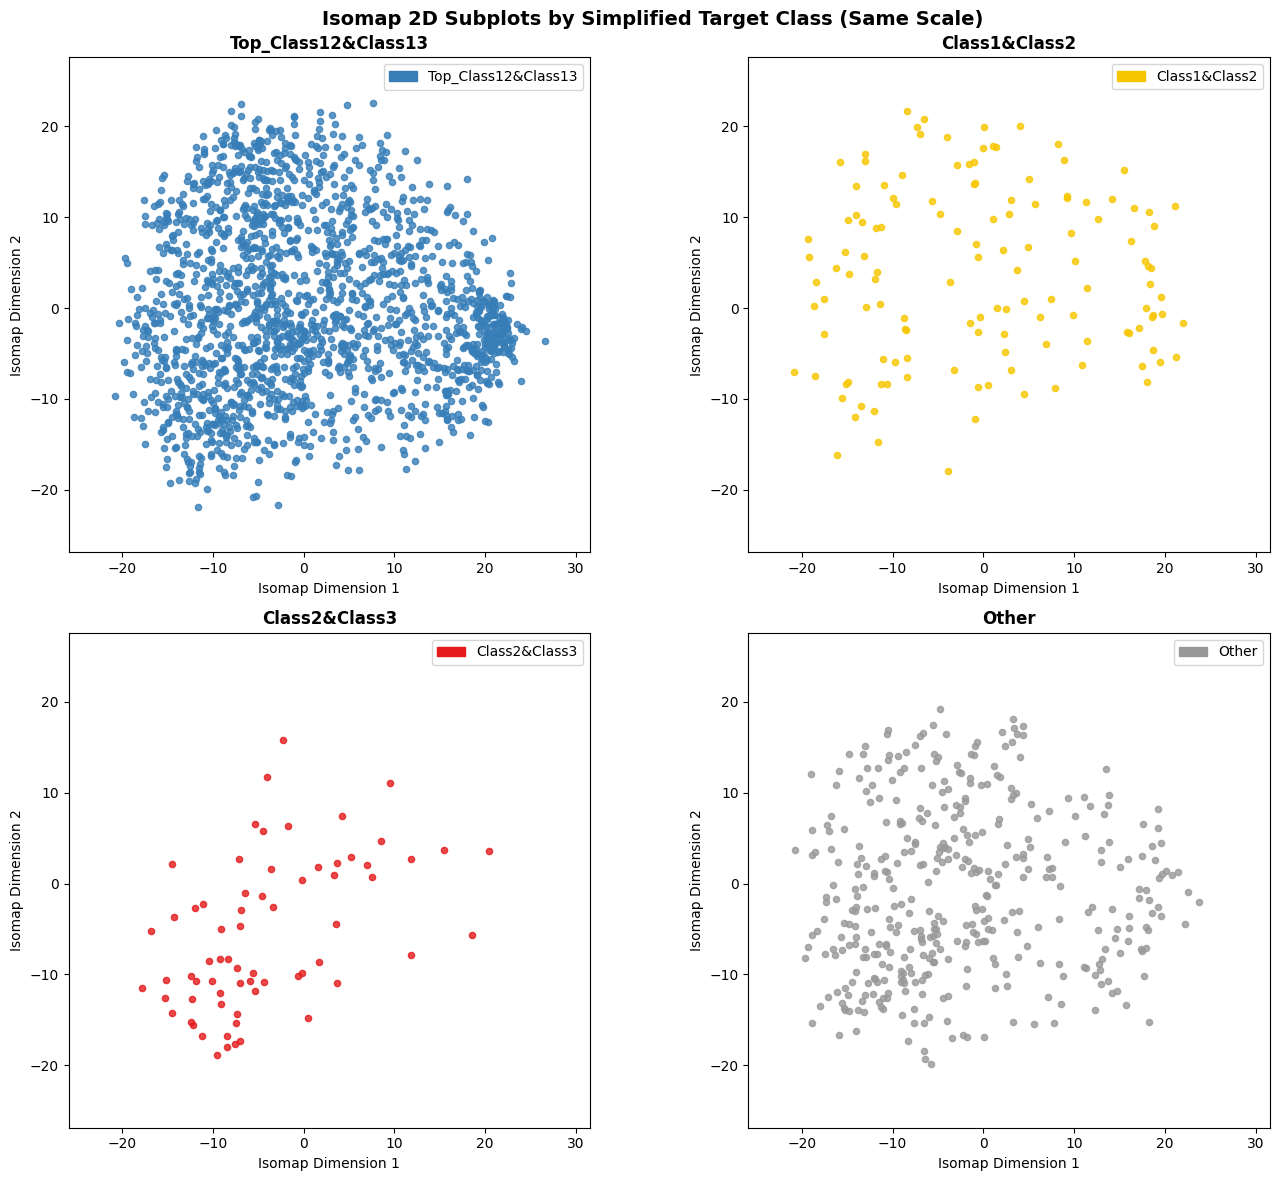

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Determine common scale from full Isomap for consistency across subplots
x_min, x_max = X_isomap[:, 0].min() - 5, X_isomap[:, 0].max() + 5
y_min, y_max = X_isomap[:, 1].min() - 5, X_isomap[:, 1].max() + 5

# Plot each class in its subplot with same axis limits
for idx, class_label in enumerate(unique_classes):
    ax = axes[idx]
    class_idx = Y_merged['SimplifiedTarget'] == class_label
    ax.scatter(
        X_isomap[class_idx, 0], 
        X_isomap[class_idx, 1], 
        c=[class2color[class_label]], 
        s=20, alpha=0.8, 
        label=class_label
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.set_title(f'{class_label}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Isomap Dimension 1')
    ax.set_ylabel('Isomap Dimension 2')
    legend_handle = mpatches.Patch(color=class2color[class_label], label=class_label)
    ax.legend(handles=[legend_handle], loc='upper right')

fig.suptitle('Isomap 2D Subplots by Simplified Target Class (Same Scale)', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

### Comparison and Curvature [10]

Isomap is generally better at revealing the global structure of the gene expression data. Unlike t-SNE, which focuses on preserving the local neighborhoods of points and can sometimes fracture the broader arrangement of clusters, Isomap aims to preserve the geodesic distances between all points. This means Isomap attempts to "unroll" the underlying manifold of the data, providing a clearer picture of the overall relationships and distances between different functional categories, as seen in the more contiguous, though overlapping, arrangement of its clusters.

**What is the concept of the data manifold?**

The concept of a data manifold refers to the underlying smooth, possibly non-linear surface that the high-dimensional data lies on. The Isomap plots suggest that the yeast gene expression manifold is highly curved and complex, as points do not align just along simple axes but occupy a rounded, nearly circular area with many local twists and turns. This curvature is apparent from the way clusters are spread—without isolated, straight-line boundaries and how manifold neighborhoods wrap around each other rather than separate cleanly.

**Manifold Complexity and Classification Difficulty**

A highly curved and intricate manifold, as shown in the Isomap plot, increases the difficulty of classification. In such cases, simple linear classifiers or algorithms relying on fixed boundaries struggle because the true data separation follows convoluted, non-linear trajectories. This means that samples from different classes may be close together in the embedding or intermixed due to overlapping manifold regions, requiring more sophisticated, non-linear approaches or manifold-aware models to achieve accurate classification results on gene expression data.